### From this program learnings are
1.  Resnet18 
2. Tranfer learning by freezing the layers 
3.  Use of grad-CAM to check where the kernel is looking or analyzing 

###installation of Keras

In [0]:
import keras

### Trained image classifiers are present in this package (https://pypi.org/project/image-classifiers/) 

In [4]:
pip install image-classifiers

     |████████████████████████████████| 81kB 3.2MB/s 


### Create a base model of ResNet18

ResNet-18 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 18 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. 
https://www.mathworks.com/help/deeplearning/ref/resnet18.html

Note: to change the input size according to the image size in hand
This is possible when there is no fully connected layer at the end
So in this tranfer-learning, if pre-trained model contains FC layer than remove it using include_top = False 

In [5]:
from classification_models.resnet import ResNet18, preprocess_input

base_model = ResNet18((32, 32, 3), weights='imagenet', include_top=False)

W0710 13:47:17.472418 139715639162752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 13:47:17.537541 139715639162752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 13:47:17.538844 139715639162752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 13:47:17.540486 139715639162752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 13:47:17.542133 139715

44924928/44920640 [==============================] - 4s 0us/step


###Check the summary, FC layer is removed

In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

###Note: every architecture has its own preprocessing unit

so that input images are processed according to the model requirement
Preprocessing unit might do decoding, cropping, resizing, smoothing, edge sharpening etc

So before sending directly the input images to the model its recommanded to preprocess them using preprocessing unit

In [0]:
from keras.datasets import cifar10
from skimage.transform import resize
import numpy as np
from keras.utils.np_utils import to_categorical

Spilt the test and tain data 
Here labels are in numbers so change to one hot encoding

In [8]:
# The data, split between train and test sets:
(X, y), (xt, yt) = cifar10.load_data()

# create output catagorical
ytrain=to_categorical(y)
ytrain=np.array(ytrain)
print(y)
print(ytrain)

Xp = preprocess_input(X)
print(Xp.shape)

Xtest = preprocess_input(xt)
print(Xtest.shape)

170500096/170498071 [==============================] - 11s 0us/step
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(50000, 32, 32, 3)
(10000, 32, 32, 3)


###Freezing layers of base model
Good thing to do is first freeze all layers, then make true required layers

In [9]:
# Freeze the layers of base_model
for layer in base_model.layers:
    layer.trainable = False
  
for layer in base_model.layers[-4:]:
  layer.trainable = True
  
# Check the trainable status of the individual layers
for layer in base_model.layers:
     print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f11cba9b9b0> False
<keras.layers.normalization.BatchNormalization object at 0x7f11cba9b8d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f1212de8b38> False
<keras.layers.convolutional.Conv2D object at 0x7f11cb3aaf60> False
<keras.layers.normalization.BatchNormalization object at 0x7f11c1d48cf8> False
<keras.layers.core.Activation object at 0x7f11c1d48e10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f11c1cbe780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f11c1c92a58> False
<keras.layers.normalization.BatchNormalization object at 0x7f11c1ced630> False
<keras.layers.core.Activation object at 0x7f11c1c32630> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f11c1ba8160> False
<keras.layers.convolutional.Conv2D object at 0x7f11c1ba8f98> False
<keras.layers.normalization.BatchNormalization object at 0x7f11c1b40d68> False
<keras.layers.core.Activation object at 0x7f11c1b212b0> False
<keras

###What is the difference between using convolution layer and dense layer?

In [10]:
from keras.models import Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Conv2D
n_classes=10

additional_layer = Conv2D(n_classes, (1,1),strides=(1,1), padding='same', name='Conv_1', use_bias=False)(base_model.output)

additional_layer = GlobalAveragePooling2D()(additional_layer)
output = Activation('softmax')(additional_layer)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

### compiling and training

In [11]:
 from keras import optimizers
 sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
 model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
 model.fit(Xp, ytrain, epochs=20)

W0710 13:47:45.009280 139715639162752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 13:47:45.144493 139715639162752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
50000/50000 [==============================] - 38s 753us/step - loss: 1.5701 - acc: 0.4641
Epoch 2/20
50000/50000 [==============================] - 35s 694us/step - loss: 1.3072 - acc: 0.5447
Epoch 3/20
50000/50000 [==============================] - 34s 689us/step - loss: 1.2407 - acc: 0.5646
Epoch 4/20
50000/50000 [==============================] - 34s 689us/step - loss: 1.1996 - acc: 0.5768
Epoch 5/20
50000/50000 [==============================] - 34s 690us/step - loss: 1.1778 - acc: 0.5850
Epoch 6/20
50000/50000 [==============================] - 35s 693us/step - loss: 1.1499 - acc: 0.5938
Epoch 7/20
50000/50000 [==============================] - 35s 694us/step - loss: 1.1334 - acc: 0.6047
Epoch 8/20
50000/50000 [==============================] - 34s 689us/step - loss: 1.1164 - acc: 0.6063
Epoch 9/20
50000/50000 [==============================] - 34s 680us/step - loss: 1.0998 - acc: 0.6122
Epoch 10/20
50000/50000 [==============================] - 34s 682us/step - loss: 

###Predictions

In [0]:
preds = model.predict(Xtest)

http://www.hackevolve.com/where-cnn-is-looking-grad-cam/

Compute the gradient of the class output value with respect to the feature map. Then, we pool the gradients over all the axes leaving out the channel dimension. Finally, we weigh the output feature map with the computed gradient values.

We then average the weighed feature map along the channel dimension resulting in a heat map of size 14 \times 14. And, then we normalize the heat map to make the values in between 0 and 1.

Actual: cat Predicted: automobile


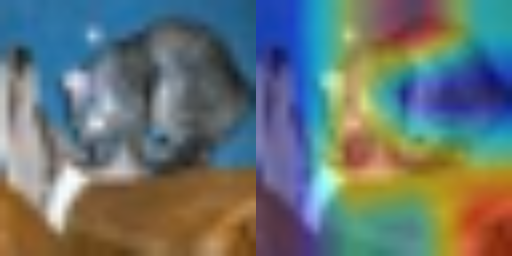

Actual: ship Predicted: automobile


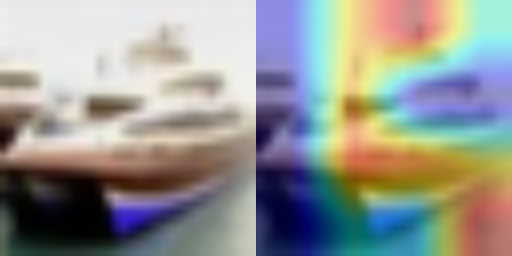

Actual: ship Predicted: truck


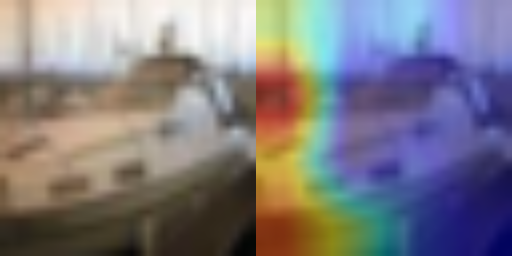

Actual: airplane Predicted: truck


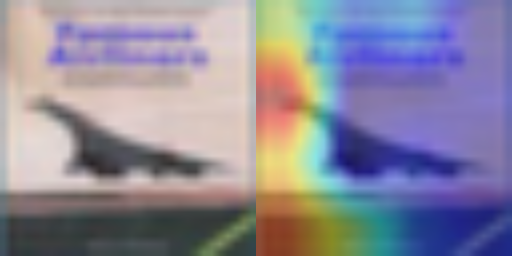

Actual: frog Predicted: truck


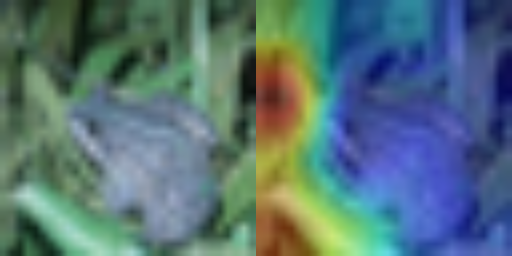

Actual: frog Predicted: dog


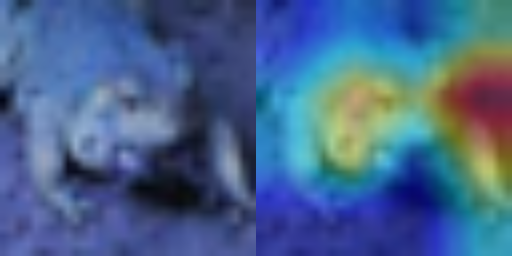

Actual: frog Predicted: truck


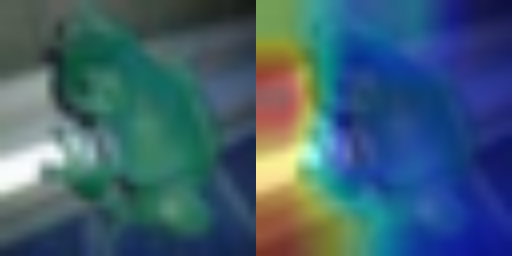

Actual: cat Predicted: dog


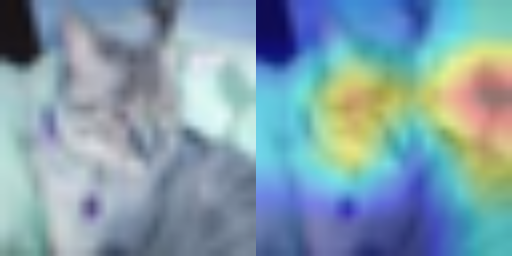

Actual: automobile Predicted: truck


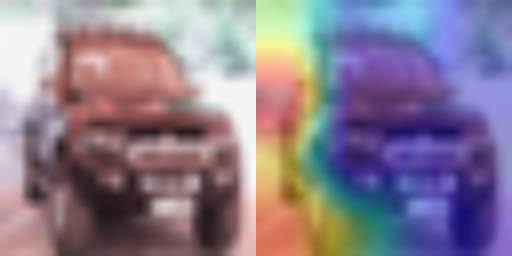

Actual: dog Predicted: automobile


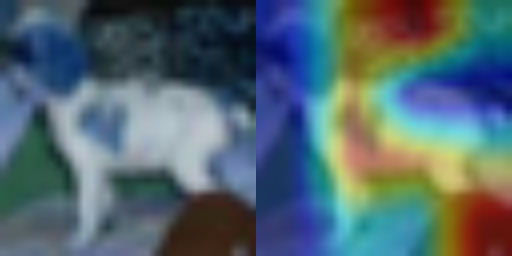

Actual: ship Predicted: automobile


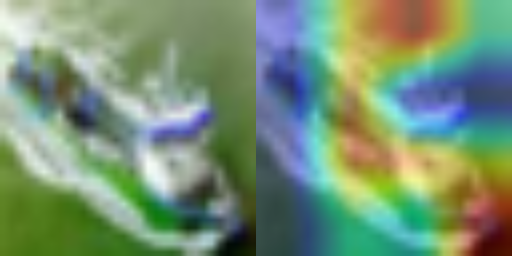

Actual: dog Predicted: cat


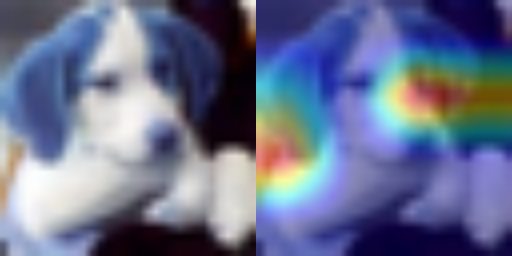

Actual: horse Predicted: automobile


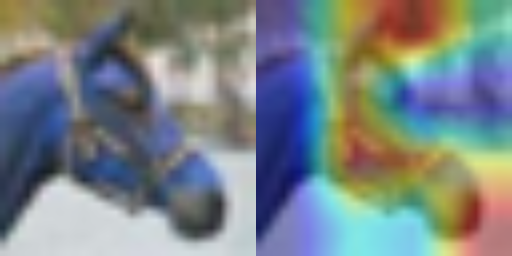

Actual: ship Predicted: truck


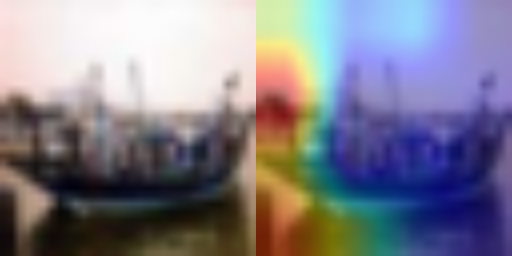

Actual: horse Predicted: truck


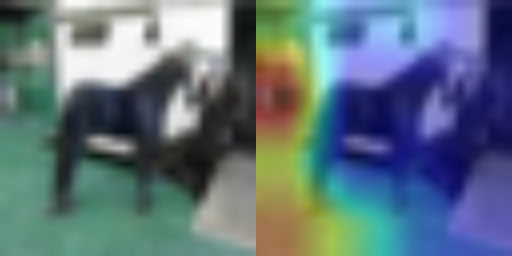

Actual: dog Predicted: automobile


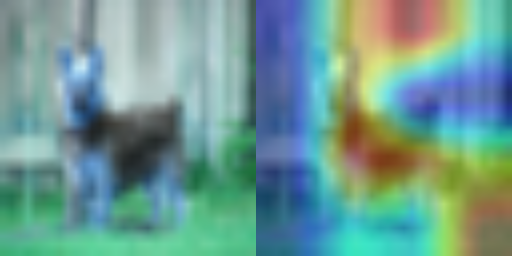

Actual: deer Predicted: horse


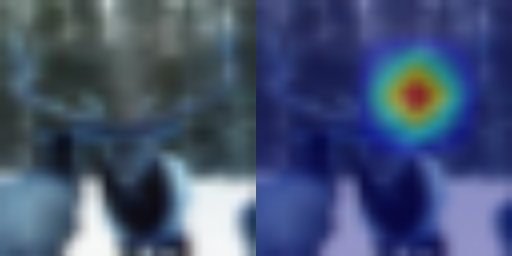

Actual: airplane Predicted: horse


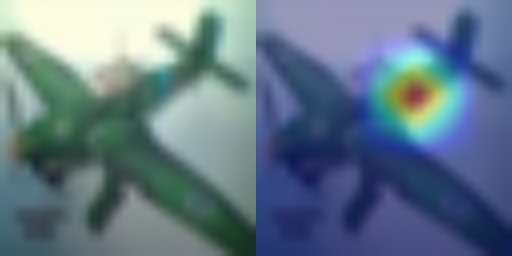

Actual: frog Predicted: automobile


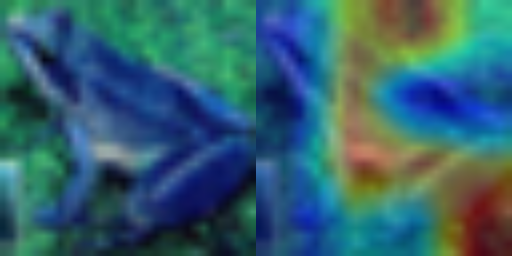

Actual: deer Predicted: automobile


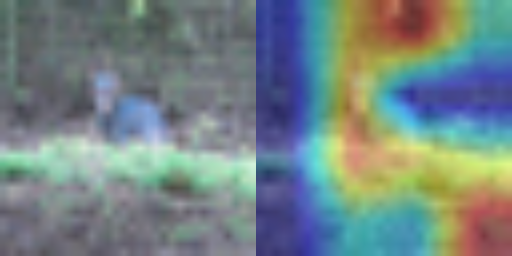

Actual: bird Predicted: dog


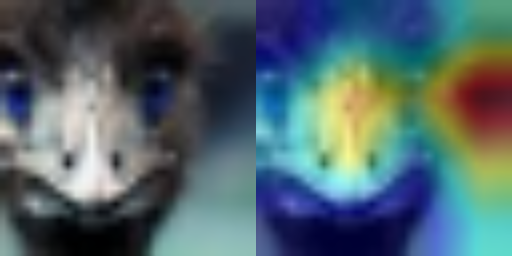

Actual: deer Predicted: horse


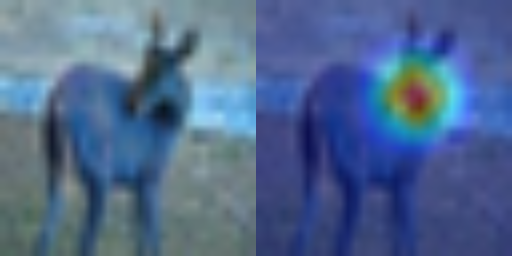

Actual: automobile Predicted: truck


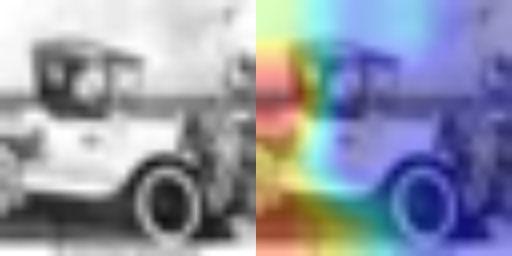

Actual: deer Predicted: truck


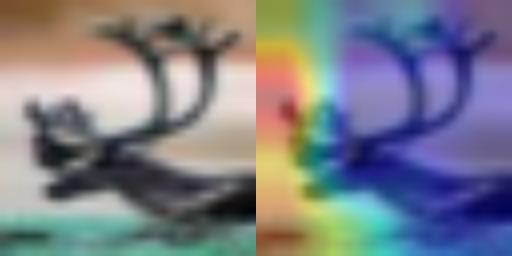

Actual: frog Predicted: truck


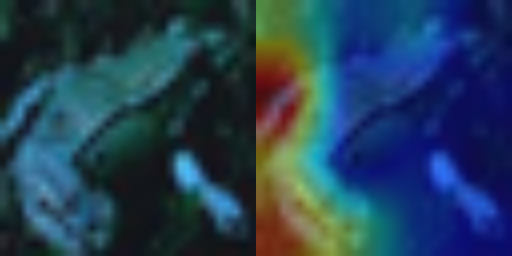

Actual: frog Predicted: dog


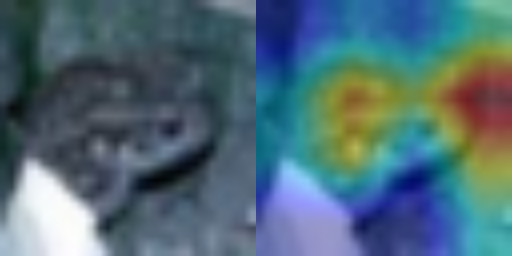

Actual: airplane Predicted: automobile


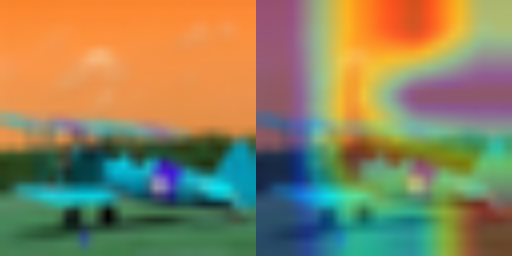

Actual: frog Predicted: dog


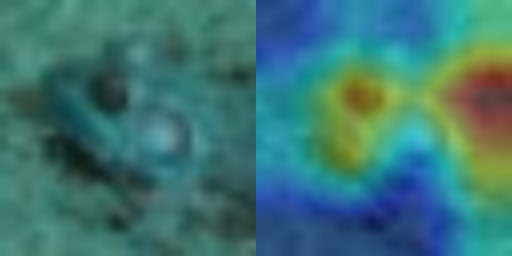

Actual: ship Predicted: truck


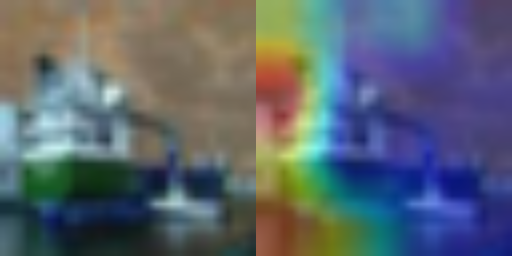

Actual: airplane Predicted: dog


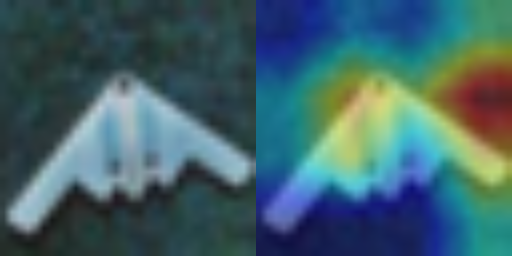

Actual: cat Predicted: dog


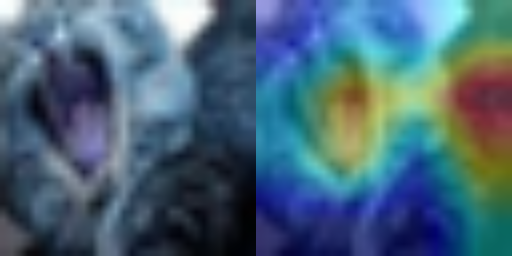

Actual: horse Predicted: dog


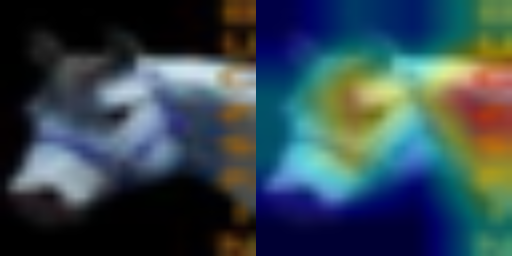

Actual: deer Predicted: dog


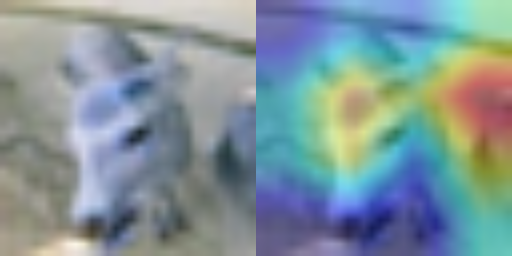

Actual: frog Predicted: dog


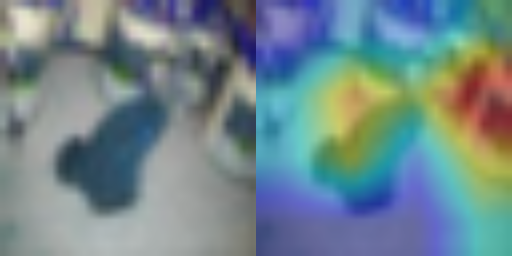

Actual: frog Predicted: truck


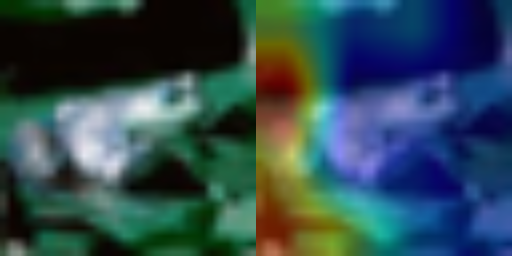

Actual: cat Predicted: truck


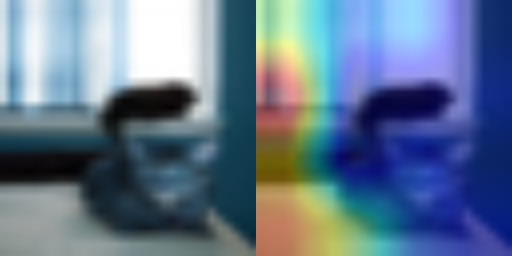

Actual: frog Predicted: dog


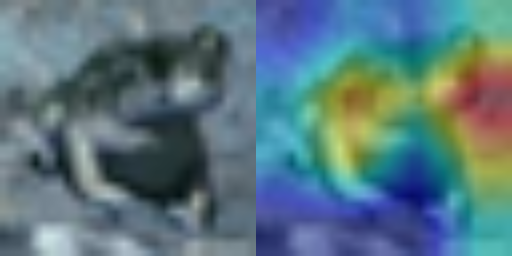

Actual: cat Predicted: truck


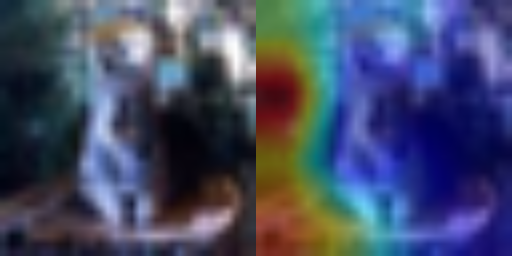

Actual: horse Predicted: truck


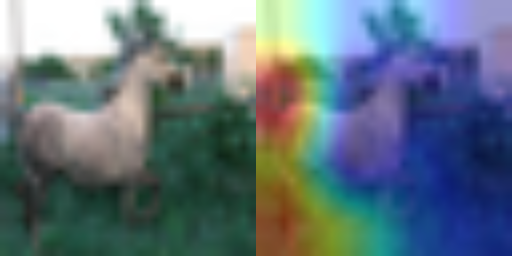

Actual: bird Predicted: ship


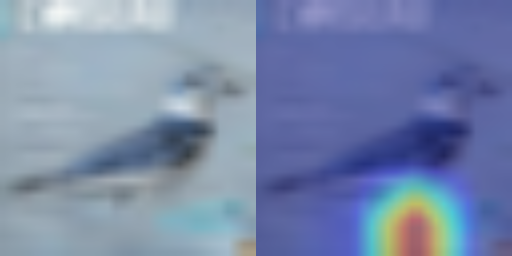

Actual: frog Predicted: dog


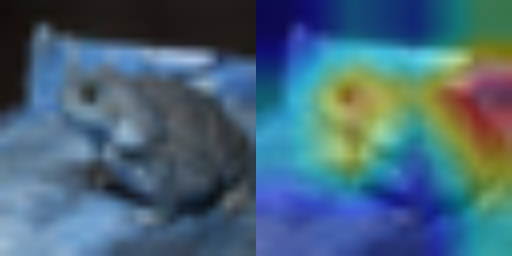

Actual: ship Predicted: airplane


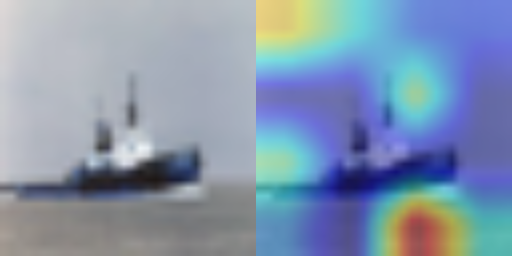

Actual: airplane Predicted: truck


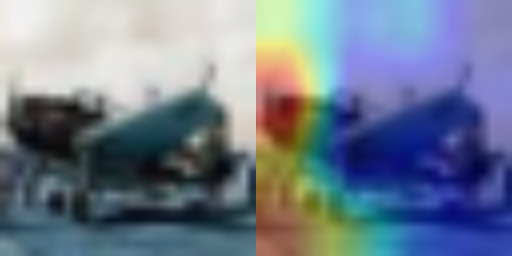

Actual: truck Predicted: airplane


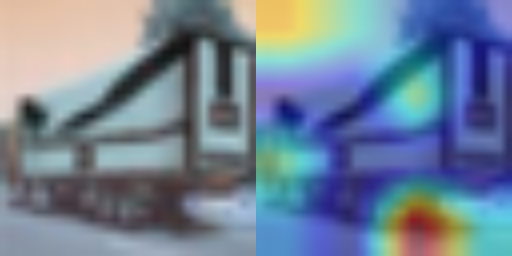

Actual: cat Predicted: automobile


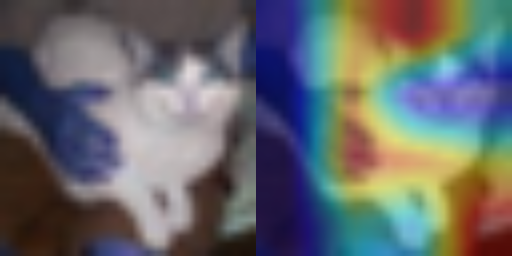

Actual: cat Predicted: dog


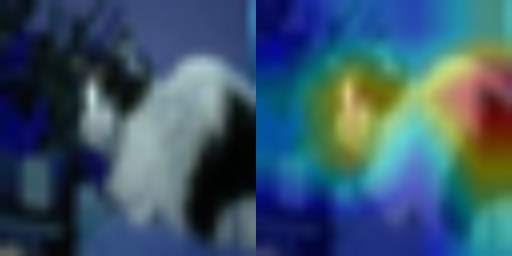

Actual: automobile Predicted: truck


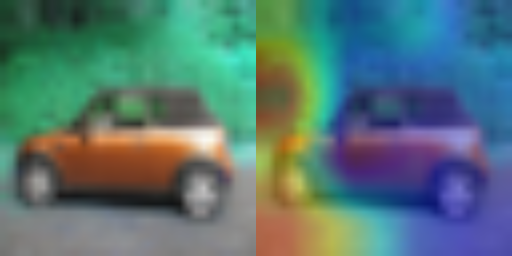

Actual: dog Predicted: horse


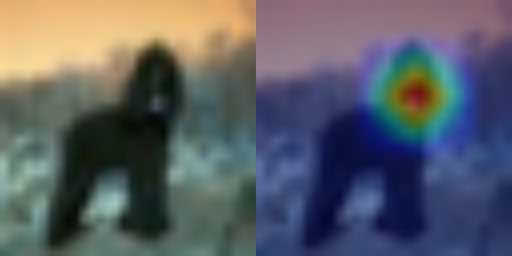

Actual: bird Predicted: truck


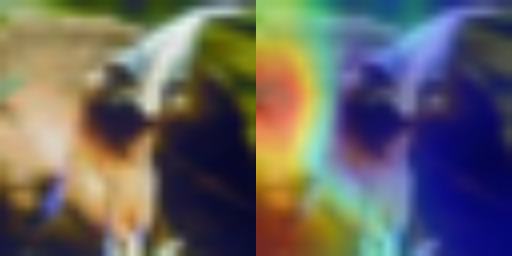

Actual: horse Predicted: truck


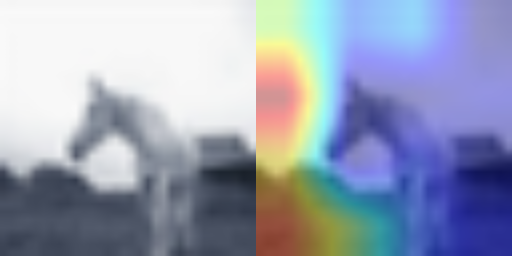

In [31]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

#List of labels
label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog","horse", "ship", "truck"]
#label_vec= cifar10.classnames()

displayImgCount = 0
for i in range(0,(len(preds)-1)):
  if(displayImgCount!=50):    
    class_idx = np.argmax(preds[i])
    if (yt[i]!=class_idx):
      actual_label = int(yt[i])
      displayImgCount = displayImgCount+1
      output = model.output[:, class_idx]
      last_conv_layer = model.get_layer("stage2_unit1_conv1")
      grads = K.gradients(output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
      pooled_grads_value, conv_layer_output_value = iterate([Xtest])
      for cc in range(128):
          conv_layer_output_value[:, :, cc] *= pooled_grads_value[cc]

      heatmap = np.mean(conv_layer_output_value, axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
      
      img = Xtest[i]
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

      img = cv2.resize(img,(256,256))
      superimposed_img = cv2.resize(superimposed_img,(256,256))
      numpy_horizontal_concat = np.concatenate((img, superimposed_img), axis=1)
      print('Actual:',label_list[actual_label],"Predicted:",label_list[class_idx])
      cv2_imshow(numpy_horizontal_concat)